# Import library

In [79]:
import rasterio
import torchgeo
import torch
import torch.nn as nn
import rioxarray
import numpy as np
import matplotlib.pyplot as plt

# Define function

In [80]:
# create image patches
# inherit from torch.nn.Module class
class Patchify(nn.Module):
    def __init__(self, patch_size=256):
        super().__init__()  # call the __init__ function of the parent class
        self.p = patch_size
        # unfold function is for extracting patches
        self.unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size) # stride = patch_size to avoid overlapping patches

    def forward(self, x):
        # x is input tensor
        # x -> Batch size, channels, height, width
        print(x)
        bs, c, h, w = x.shape
        
        x = self.unfold(x)
        # x -> Batch size, (channels*patch size*patch size), L (number of patches)
        
        # Reshaping into the shape we want -> view() helps flatten the input
        a = x.view(bs, c, self.p, self.p, -1).permute(0, 4, 1, 2, 3)
        # a -> ( B no.of patches c p p )
        return a

# Import data

## Sentinel-2 image

In [81]:
sentinel2_path = '../data/raw/sentinel-2/sentinel2_openeo_med_4months_dresden.geotiff'
data = rioxarray.open_rasterio(sentinel2_path)

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

In [82]:
data.band

<xarray.DataArray 'band' (band: 13)> Size: 104B
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
Coordinates:
  * band         (band) int64 104B 1 2 3 4 5 6 7 8 9 10 11 12 13
    spatial_ref  int64 8B 0

In [83]:
data.sel(band=1).dtype

dtype('int16')

Min and max normalization give the worst result according to https://medium.com/sentinel-hub/how-to-normalize-satellite-images-for-deep-learning-d5b668c885af

In [84]:
# Normalize the bands to the range [0, 1]
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

In [85]:
# 2th percentile to 98th percentile
# Apply a percentile-based contrast stretch (ignore the extreme values so image isn't too dark or too bright)
def contrast_stretch(array, lower_percentile=2, upper_percentile=98):
    lower = np.percentile(array, lower_percentile)
    upper = np.percentile(array, upper_percentile)
    array = np.clip(array, lower, upper) # clip -> limit the values in an array to specific range
    return (array - lower) / (upper - lower) # normalization

In [86]:
# 1th percentile to 99th percentile
# Apply a percentile-based contrast stretch (ignore the extreme values so image isn't too dark or too bright)
def contrast_stretch_new(array, lower_percentile=1, upper_percentile=99):
    lower = np.percentile(array, lower_percentile)
    upper = np.percentile(array, upper_percentile)
    print('lower: ', lower)
    print('upper: ', upper)
    array = np.clip(array, lower, upper) # clip -> limit the values in an array to specific range
    return (array - lower) / (upper - lower) # normalization

lower:  4.0
upper:  4145.0


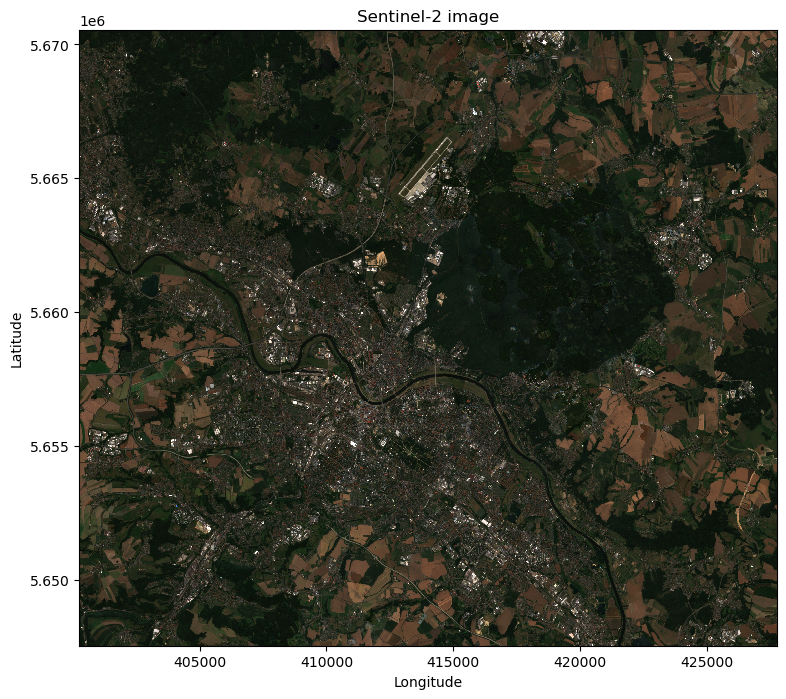

In [87]:
# Plot the raster data
plt.figure(figsize=(9,8))
# normalize(data).sel(band=[4, 3, 2]).plot.imshow()
contrast_stretch_new(data).sel(band=[4, 3, 2]).plot.imshow()
plt.title("Sentinel-2 image")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Binary mask

In [90]:
mask_path = '../data/processed/osm/public_green_spaces_dresden.geotiff'

In [91]:
mask_data = rioxarray.open_rasterio(mask_path)

In [92]:
mask_data.band

<xarray.DataArray 'band' (band: 1)> Size: 8B
array([1])
Coordinates:
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0

In [93]:
mask_data.dtype

dtype('uint8')

In [94]:
mask_data = mask_data.astype('float32')

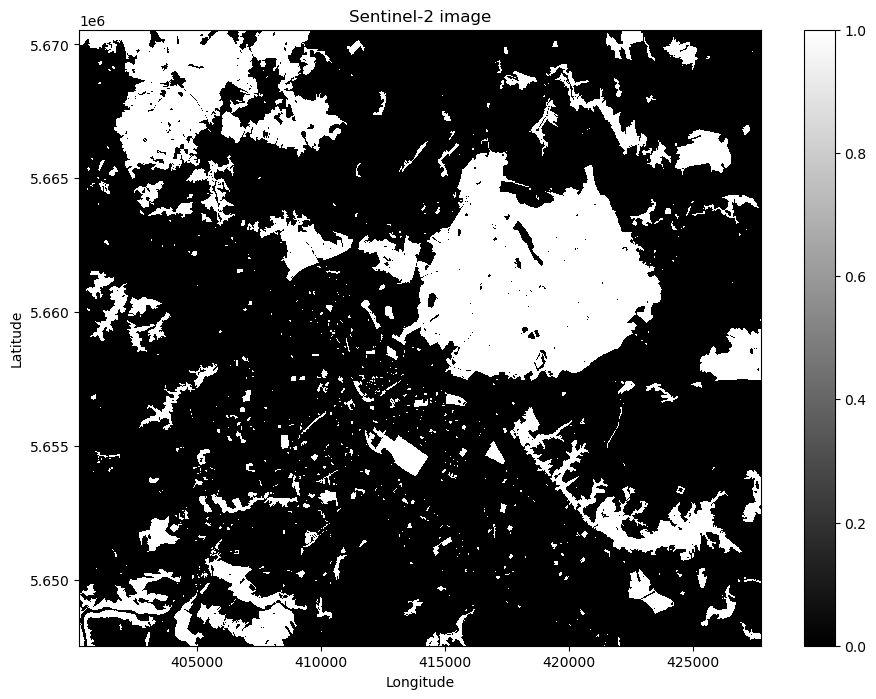

In [95]:
# Plot the raster data
plt.figure(figsize=(11,8))
# normalize(data).sel(band=[4, 3, 2]).plot.imshow()
mask_data.sel(band=1).plot.imshow(cmap='gray')
plt.title("Sentinel-2 image")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Create image patches (use unfold function -> pytorch)

In [ ]:
patch = Patchify()

# Convert DataArray to NumPy array
# img = contrast_stretch(data).sel(band=[4, 3, 2]).values  # Convert xarray DataArray to NumPy

img = contrast_stretch(data).values
print("img length:", len(img))

# Check if it's a multi-band image
# if len(img.shape) == 3:  
#     img = np.stack([img[0], img[1], img[2]], axis=-1)  # RGB bands

# image = img.astype('float32') / 255.0  # Normalize to [0, 1]
image = torch.from_numpy(img)
print("image shape:", image.shape)

# image = image.permute(2, 0, 1) # change the order of the dimensions (height, width, channels) to (channels, height, width)
image = image.unsqueeze(0) # to add the batch dimension in the 0th position

p = patch(image)
p = p.squeeze() # to remove the batch dimension for plotting

In [ ]:
print(p.shape)

torch.Size([80, 13, 256, 256])


In [96]:
mask_img = mask_data.values
print("mask img length:", len(mask_img))

# Check if it's a multi-band image
# if len(img.shape) == 3:  
#     img = np.stack([img[0], img[1], img[2]], axis=-1)  # RGB bands

# image = img.astype('float32') / 255.0  # Normalize to [0, 1]
mask_image = torch.from_numpy(mask_img)
print("mask image shape:", mask_image.shape)

# image = image.permute(2, 0, 1) # change the order of the dimensions (height, width, channels) to (channels, height, width)
mask_image = mask_image.unsqueeze(0) # to add the batch dimension in the 0th position

mask_p = patch(mask_image)
mask_p = mask_p.squeeze() # to remove the batch dimension for plotting

mask img length: 1
mask image shape: torch.Size([1, 2301, 2747])
tensor([[[[1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.]]]])


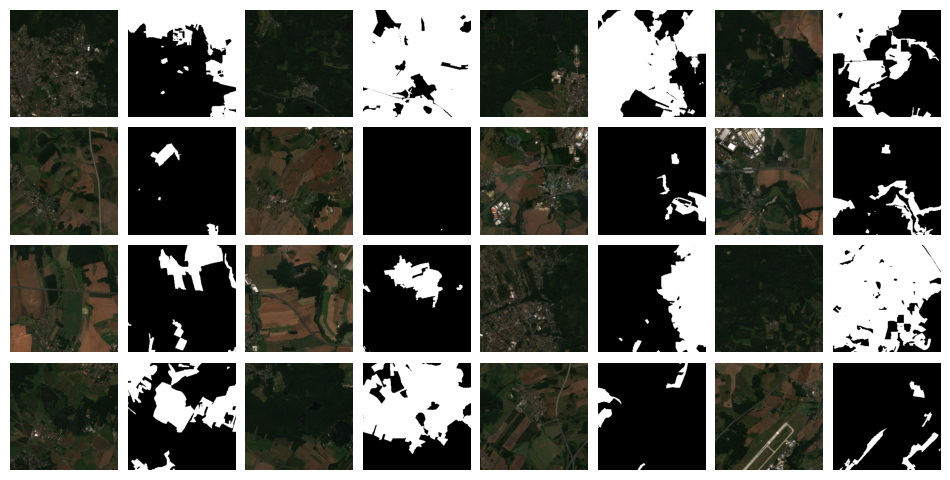

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_patches(image_tensor, mask_tensor):
    fig = plt.figure(figsize=(12, 12))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.1)
    for i in range(int(len(grid)/2)):
        # plot the image patch
        temp_tensor = image_tensor[i].permute(1, 2, 0)
        patch = np.stack([temp_tensor[:, :, 3], temp_tensor[:, :, 2], temp_tensor[:, :, 1]], axis=-1)  # RGB bands
        ax_image = grid[2 * i]
        # format of imshow function is (height, width, channels)
        ax_image.imshow(patch)
        ax_image.axis('off')

        # plot the corresponding mask
        mask = mask_tensor[i].squeeze()
        ax_mask = grid[2 * i + 1]
        ax_mask.imshow(mask, cmap='gray')
        ax_mask.axis('off')

    # for i, ax in enumerate(grid):
    #     temp_tensor = tensor[i].permute(1, 2, 0)
    #     patch = np.stack([temp_tensor[:,:,3], temp_tensor[:,:,2], temp_tensor[:,:,1]], axis=-1)  # RGB bands
    #     # format of imshow function is (height, width, channels)
    #     ax.imshow(patch)
    #     ax.axis('off')

    plt.show()

plot_patches(p, mask_p)

In [98]:
# from mpl_toolkits.axes_grid1 import ImageGrid

# def plot_patches(tensor):
#     fig = plt.figure(figsize=(10, 10))
#     grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)

#     for i, ax in enumerate(grid):
#         print(tensor[i].shape)
#         # temp_tensor = tensor[i].permute(1, 2, 0)
#         # patch = np.stack([temp_tensor[:,:,3], temp_tensor[:,:,2], temp_tensor[:,:,1]], axis=-1)  # RGB bands
#         # format of imshow function is (height, width, channels)
#         ax.imshow(tensor[i], cmap='gray')
#         ax.axis('off')

#     plt.show()

# plot_patches(mask_p)

# Create image patches (Torchgeo)

## Create ROI for training, validation, and test set

manually specify

In [24]:
# rds = rioxarray.open_rasterio(sentinel2_path).isel(band=0)

# # Get the bounds of the image
# xmin, ymin, xmax, ymax = rds.rio.bounds()

# # Define ROI by splitting into three equal parts (Train, Validation, Test)
# # width = (xmax-xmin) / 3  # Divide the image into 3 parts
# # height = (ymax-ymin) / 3

# roi1_width = (50*(xmax - xmin))/100
# # roi1_height = (70*(ymax - ymin))/100

# # Tile
# roi_1 = [xmin, ymin, xmin + roi1_width, ymax]
# roi_2 = [xmin + roi1_width, ymin, xmax, ymax]

# print("ROI 1:", roi_1)
# print("ROI 2:", roi_2)

# # train_roi = [xmin, ymin, xmin + width, ymax]
# # val_roi = [xmin + width, ymin, xmin + 2 * width, ymax]
# # test_roi = [xmin + 2 * width, ymin, xmax, ymax]

# # print("Train ROI:", train_roi)
# # print("Validation ROI:", val_roi)
# # print("Test ROI:", test_roi)

In [25]:
# import matplotlib.patches as patches
# # Create figure
# fig, ax = plt.subplots(figsize=(10, 10))

# # Plot the satellite image
# rds.plot.imshow(ax=ax, cmap="gray", robust=True)

# # Function to draw ROI boxes
# def draw_box(ax, roi, color, label):
#     """Draws a rectangle for ROI"""
#     xmin, ymin, xmax, ymax = roi
#     width = xmax - xmin
#     height = ymax - ymin
#     rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor=color, facecolor="none", label=label)
#     ax.add_patch(rect)

# # Draw ROIs
# draw_box(ax, roi_1, "red", "roi 1")
# draw_box(ax, roi_2, "blue", "roi 2")
# # draw_box(ax, test_roi, "green", "Test")

# # Add legend and show the plot
# plt.legend()
# plt.title("ROIs Over Satellite Image")
# plt.show()

In [ ]:
from torchgeo.datasets import RasterDataset, VectorDataset, unbind_samples, stack_samples, Sentinel2
from pyproj import CRS

train_ds = RasterDataset(paths=sentinel2_path, crs=CRS.from_epsg(32633), res=10)

In [ ]:
train_ds.bounds

BoundingBox(minx=400260.0, maxx=427730.0, miny=5647540.0, maxy=5670550.0, mint=0.0, maxt=9.223372036854776e+18)

In [ ]:
from torchgeo.samplers import RandomGeoSampler
sampler = RandomGeoSampler(train_ds, size=(512, 512), length=100)

In [ ]:
import torch

torch.manual_seed(0) # this is to get the same result in every pass
bbox = next(iter(sampler))
print(bbox)
sample = train_ds[bbox]
print(sample.keys())
print(sample['image'].shape)

BoundingBox(minx=402230.0, maxx=407350.0, miny=5649900.0, maxy=5655020.0, mint=0.0, maxt=9.223372036854776e+18)
dict_keys(['crs', 'bounds', 'image'])
torch.Size([13, 512, 512])


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

lower:  4.0
upper:  4206.0
(13, 512, 512)


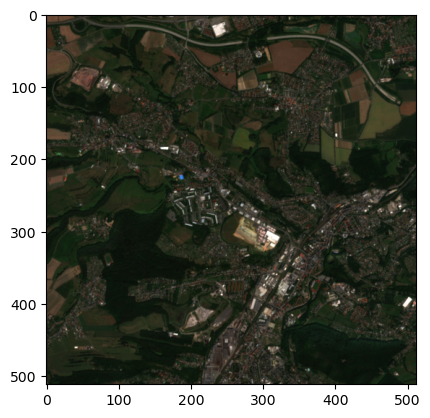

In [ ]:
import torch
import matplotlib.pyplot as plt

# arr = torch.clamp(sample['image']/10000, min=0, max=1).numpy()
arr = contrast_stretch_new(sample['image']).numpy()
# arr = torch.from_numpy(arr)
print(arr.shape)
# Transpose the array to get the correct shape for RGB (height, width, channels)
rgb = arr.transpose(1, 2, 0)[:, :, [3, 2 , 1]]

plt.imshow(rgb)

In [ ]:
train_label = VectorDataset(paths='../data/processed/osm/public_green_spaces_dresden.geojson', crs=CRS.from_epsg(32633), res=10)

/root/miniforge3/envs/pugs-detection-new/lib/python3.12/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [ ]:
new_train_ds = train_ds & train_label

In [ ]:
from torchgeo.samplers import RandomGeoSampler
sampler = RandomGeoSampler(new_train_ds, size=(128, 128), length=100)

In [ ]:
torch.manual_seed(0)
bbox = next(iter(sampler))
sample = new_train_ds[bbox]
print(sample.keys())
print(sample['image'].shape)
print(sample['mask'].shape)

dict_keys(['crs', 'bounds', 'image', 'mask'])
torch.Size([13, 128, 128])
torch.Size([128, 128])


lower:  4.0
upper:  4130.0899999999965
(13, 128, 128)


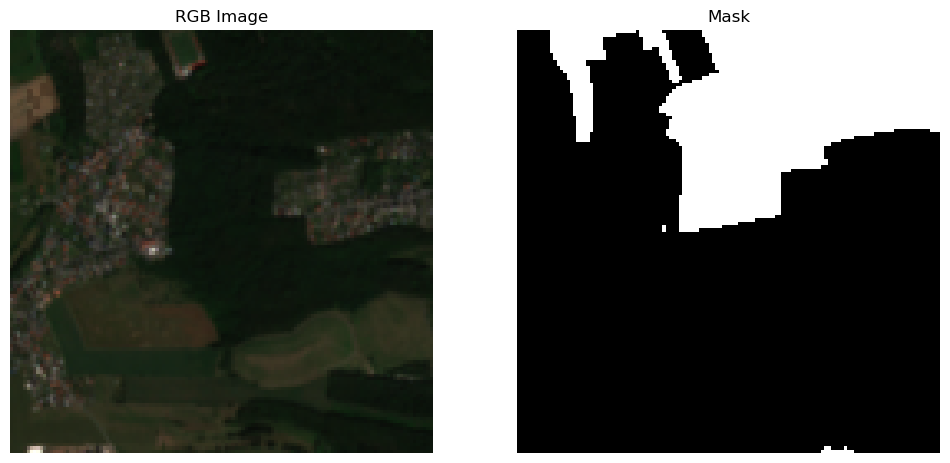

In [ ]:
arr = contrast_stretch_new(sample['image']).numpy()
mask = sample['mask'].numpy()

# Print the shape of the image array
print(arr.shape)

# Transpose the array to get the correct shape for RGB (height, width, channels)
rgb = arr.transpose(1, 2, 0)[:, :, [3, 2, 1]]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the RGB image in the first subplot
axes[0].imshow(rgb)
axes[0].set_title('RGB Image')
axes[0].axis('off')

# Display the mask in the second subplot
axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')

# Show the figure
plt.show()

lower:  4.0
upper:  4130.0899999999965
(13, 128, 128)


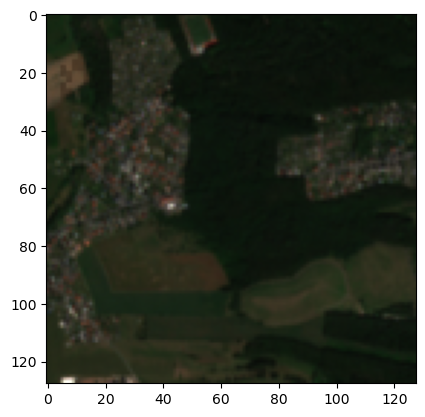

In [ ]:
import torch
import matplotlib.pyplot as plt

# arr = torch.clamp(sample['image']/10000, min=0, max=1).numpy()
arr = contrast_stretch_new(sample['image']).numpy()
# arr = torch.from_numpy(arr)
print(arr.shape)
rgb = arr.transpose(1, 2, 0)[:, :, [3, 2 , 1]]

plt.imshow(rgb)